In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class MosaicDataset1(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    #self.alpha = torch.ones((3000,9),requires_grad=True)/9
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]#,self.alpha[idx]

In [3]:
ag = []
for i in range(12):
  alphag = torch.ones((250,9))/9
  ag.append( alphag.requires_grad_() )

In [4]:
train_data = np.load("train_type4_data.npy",allow_pickle=True)

In [5]:
train_mosaic_list_of_images = train_data[0]["mosaic_list"]
train_mosaic_label = train_data[0]["mosaic_label"]
train_fore_idx = train_data[0]["fore_idx"]



batch = 250
tr_msd = MosaicDataset1(train_mosaic_list_of_images, train_mosaic_label, train_fore_idx)
train_loader = DataLoader( tr_msd,batch_size= batch ,shuffle=False,num_workers=0)

# Model

In [6]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
  

    self.fc1 = nn.Linear(2, 100)
    self.fc2 = nn.Linear(100,3)

  def forward(self,y):  #z batch of list of 9 images

    y = F.relu(self.fc1(y))
    y = self.fc2(y)
    return y

In [7]:
torch.manual_seed(1234)
what_net = Module2().double()
what_net = what_net.to("cuda")

In [8]:
def attn_avg(x,alpha):
  y = torch.zeros([batch,2], dtype=torch.float64)
  y = y.to("cuda")
  alpha = F.softmax(alpha,dim=1)   # alphas
  for i in range(9):            
    alpha1 = alpha[:,i]          
    y = y + torch.mul(alpha1[:,None],x[:,i])
    return y 


In [9]:
def calculate_attn_loss(dataloader,what,criter):
  what.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  correct = 0
  tot = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      alpha = ag[i]  # alpha for ith batch
      alpha = alpha.to("cuda")
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      avg = attn_avg(inputs,alpha)
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      correct += sum(predicted == labels)
      tot += len(predicted)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())
      loss = criter(outputs, labels)
      r_loss += loss.item()
  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,analysis,correct.item(),tot,correct.item()/tot

In [10]:

def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [11]:
def update_function(param, grad, loss, learning_rate):
  # print("param", param)
  # print("lr",learning_rate)
  # print("grad",grad)
  return param - learning_rate * grad

In [12]:
optim1 = []
for i in range(12):
  optim1.append(optim.RMSprop([ag[i]], lr=0.001))


In [13]:
optim1[0]

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)

In [14]:
# instantiate optimizer
optimizer_what = optim.RMSprop(what_net.parameters(), lr=0.001)#,nesterov=True)

 


criterion = nn.CrossEntropyLoss()
acti = []
analysis_data_tr = []
analysis_data_tst = []
loss_curi_tr = []
loss_curi_tst = []
epochs = 500
# lr = torch.tensor([0.001],device="cuda")


# calculate zeroth epoch loss and FTPT values
running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 
loss_curi_tr.append(running_loss)
analysis_data_tr.append(anlys_data)




# training starts 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what_net.train()
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    grads = [] 
    inputs, labels,_ = data
    inputs = inputs.double()
    alpha = ag[i] # alpha for ith batch
    inputs, labels,alpha = inputs.to("cuda"),labels.to("cuda"),alpha.to("cuda")

        
    # zero the parameter gradients
    optimizer_what.zero_grad()
    optim1[i].zero_grad()
    #what_net.zero_grad()
      
    # forward + backward + optimize
    avg = attn_avg(inputs,alpha)
    outputs = what_net(avg)
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    # alpha.retain_grad()
    loss.backward(retain_graph=False)
    optimizer_what.step()
    optim1[i].step()
    #print(alpha.grad)
    # with torch.no_grad():
    #   alpha.sub_(lr * alpha.grad)
    #   alpha.grad.zero_()
    # alpha_g[i*250:(i+1)*250] = alpha
    


  running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
  analysis_data_tr.append(anls_data)
  loss_curi_tr.append(running_loss_tr)   #loss per epoch
  print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tr,correct,total,accuracy)) 


  
  if running_loss_tr<=0.05:
    break
print('Finished Training run ')
analysis_data_tr = np.array(analysis_data_tr)



training epoch: [0 ] loss: 1.205 correct: 972.000, total: 3000.000, accuracy: 0.324
training epoch: [1 ] loss: 1.196 correct: 1071.000, total: 3000.000, accuracy: 0.357
training epoch: [2 ] loss: 1.193 correct: 1364.000, total: 3000.000, accuracy: 0.455
training epoch: [3 ] loss: 1.190 correct: 1226.000, total: 3000.000, accuracy: 0.409
training epoch: [4 ] loss: 1.185 correct: 1225.000, total: 3000.000, accuracy: 0.408
training epoch: [5 ] loss: 1.179 correct: 1269.000, total: 3000.000, accuracy: 0.423
training epoch: [6 ] loss: 1.171 correct: 1292.000, total: 3000.000, accuracy: 0.431
training epoch: [7 ] loss: 1.160 correct: 1256.000, total: 3000.000, accuracy: 0.419
training epoch: [8 ] loss: 1.148 correct: 1250.000, total: 3000.000, accuracy: 0.417
training epoch: [9 ] loss: 1.134 correct: 1275.000, total: 3000.000, accuracy: 0.425
training epoch: [10 ] loss: 1.120 correct: 1297.000, total: 3000.000, accuracy: 0.432
training epoch: [11 ] loss: 1.104 correct: 1318.000, total: 3000.

In [15]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = np.arange(0,epoch+2)
df_train[columns[1]] = analysis_data_tr[:,-2]
df_train[columns[2]] = analysis_data_tr[:,-1]
df_train[columns[3]] = analysis_data_tr[:,0]
df_train[columns[4]] = analysis_data_tr[:,1]
df_train[columns[5]] = analysis_data_tr[:,2]
df_train[columns[6]] = analysis_data_tr[:,3]

In [16]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,3000,108,864,246,1782
1,1,0,3000,157,914,187,1742
2,2,0,3000,221,1143,127,1509
3,3,0,3000,196,1030,169,1605
4,4,0,3000,201,1024,162,1613
...,...,...,...,...,...,...,...
102,102,0,3000,305,2693,0,2
103,103,0,3000,305,2693,0,2
104,104,0,3000,305,2695,0,0
105,105,0,3000,305,2695,0,0


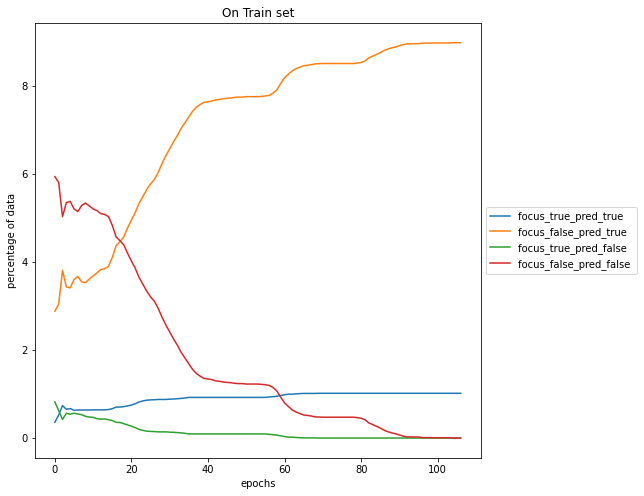

In [17]:
fig= plt.figure(figsize=(8,8))
plt.plot(df_train[columns[0]],df_train[columns[3]]/300, label ="focus_true_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[4]]/300, label ="focus_false_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[5]]/300, label ="focus_true_pred_false ")
plt.plot(df_train[columns[0]],df_train[columns[6]]/300, label ="focus_false_pred_false ")
plt.title("On Train set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("percentage of data")
#plt.vlines(vline_list,min(min(df_train[columns[3]]/300),min(df_train[columns[4]]/300),min(df_train[columns[5]]/300),min(df_train[columns[6]]/300)), max(max(df_train[columns[3]]/300),max(df_train[columns[4]]/300),max(df_train[columns[5]]/300),max(df_train[columns[6]]/300)),linestyles='dotted')
plt.show()
fig.savefig("train_analysis_every_20.pdf")
fig.savefig("train_analysis_every_20.png")

In [18]:
aph = []
for i in ag:
  aph.append(F.softmax(i,dim=1).detach().numpy())
  
aph = np.concatenate(aph,axis=0)
torch.save({
            'epoch': 500,
            'model_state_dict': what_net.state_dict(),
            'optimizer_state_dict': optimizer_what.state_dict(),
            "optimizer_alpha":optim1,
            "FTPT_analysis":analysis_data_tr,
            "alpha":aph

            }, "type4_what_net_500.pt")

In [19]:
aph

array([[0.17396913, 0.10325387, 0.10325387, ..., 0.10325387, 0.10325387,
        0.10325387],
       [0.14745182, 0.10656855, 0.10656855, ..., 0.10656855, 0.10656855,
        0.10656855],
       [0.08479986, 0.11440001, 0.11440001, ..., 0.11440001, 0.11440001,
        0.11440001],
       ...,
       [0.13946499, 0.10756689, 0.10756689, ..., 0.10756689, 0.10756689,
        0.10756689],
       [0.1959542 , 0.10050572, 0.10050572, ..., 0.10050572, 0.10050572,
        0.10050572],
       [0.07285917, 0.1158926 , 0.1158926 , ..., 0.1158926 , 0.1158926 ,
        0.1158926 ]], dtype=float32)